In [36]:
from sentinelhub import SHConfig

config = SHConfig()
config.sh_client_id = 'sh-fe080851-d462-4304-9f4d-1b7fd7c7dc95'
config.sh_client_secret = 'XBnxUPfjs1duw9wmexDpoVmhTbY6piHw'
config.sh_base_url = 'https://sh.dataspace.copernicus.eu'
config.sh_token_url = 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token'

In [37]:
import datetime
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.transform import from_bounds
from pathlib import Path
from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)


In [38]:
hyd_coords_wgs84 = (78.00405826,16.93264351,79.04971836,17.90150706)
resolution=(7000, 3500)
hyd_bbox = BBox(bbox=hyd_coords_wgs84, crs=CRS.WGS84)
hyd_size = bbox_to_dimensions(hyd_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {hyd_size} pixels")

Image shape at (7000, 3500) m resolution: (16, 30) pixels


In [39]:
evalscript_mean_mosaic = """
//VERSION=3
function setup() {
    return {
        input: ["O3", "dataMask"],
        output: {
            bands: 1,
            sampleType: "FLOAT32",
        },
        mosaicking: "ORBIT"
    };
}

function isClear(sample) {
    return sample.dataMask == 1;
}

function sum(array) {
    let sum = 0;
    for (let i = 0; i < array.length; i++) {
        sum += array[i].O3;
    }
    return sum;
}

function evaluatePixel(samples) {
    const clearTs = samples.filter(isClear)
    const mean = sum(clearTs) / clearTs.length
    return [mean]
}
"""

In [40]:
def get_data(time_interval):
    request = SentinelHubRequest(
        evalscript=evalscript_mean_mosaic,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL5P.define_from(
                    "s5pl2", service_url=config.sh_base_url
                ),
                time_interval=time_interval,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=hyd_bbox,
        size=hyd_size,
        config=config,
        data_folder=r"C:\Users\rishi\ml_projects\climate\temp\O3",
    )
    raw_data = request.get_data(save_data=True)
    return raw_data[0]

In [41]:
get_data(("2018-12-1", "2018-12-31"))

array([[0.10494263, 0.10474198, 0.1047272 , 0.10476069, 0.10491379,
        0.10477565, 0.1049165 , 0.10493661, 0.10469711, 0.10487331,
        0.10491942, 0.10491895, 0.10511301, 0.1050469 , 0.10499021,
        0.10510962],
       [0.10494263, 0.10491615, 0.10472735, 0.10475109, 0.10473178,
        0.10471427, 0.1048401 , 0.10484876, 0.10478455, 0.10486432,
        0.10477919, 0.10496601, 0.10486869, 0.10497682, 0.10504583,
        0.10516246],
       [0.10482862, 0.10493968, 0.10473471, 0.1046041 , 0.10484498,
        0.10482354, 0.10499037, 0.10472812, 0.10469314, 0.10466257,
        0.10488128, 0.10478216, 0.10479071, 0.10497975, 0.10502152,
        0.10509212],
       [0.10486569, 0.10482703, 0.10484613, 0.10465506, 0.10493294,
        0.10493837, 0.10489154, 0.1048334 , 0.10466398, 0.10467777,
        0.10496869, 0.10495409, 0.10492776, 0.10485398, 0.10513435,
        0.10496452],
       [0.1046871 , 0.10478875, 0.10499015, 0.10475309, 0.10477264,
        0.10485961, 0.10492537, 

In [42]:
# months = {
#     1: ("January", 31),
#     2: ("February", 28),
#     3: ("March", 31),
#     4: ("April", 30),
#     5: ("May", 31),
#     6: ("June", 30),
#     7: ("July", 31),
#     8: ("August", 31),
#     9: ("September", 30),
#     10: ("October", 31),
#     11: ("November", 30),
#     12: ("December", 31)
# }
# vals=[]
# output_dir=r"C:\Users\rishi\ml_projects\climate\2023_data\O3"
# for i in range(1,13):
#     month_name, end_day = months[i]
#     start=f"2023-{i}-1"
#     end = f"2023-{i}-{end_day}"
#     time_interval=(start,end)
#     arr=get_data(time_interval)
#     path=os.path.join(output_dir, f'{month_name}_O3.csv')
#     np.savetxt(path, arr, delimiter=',')

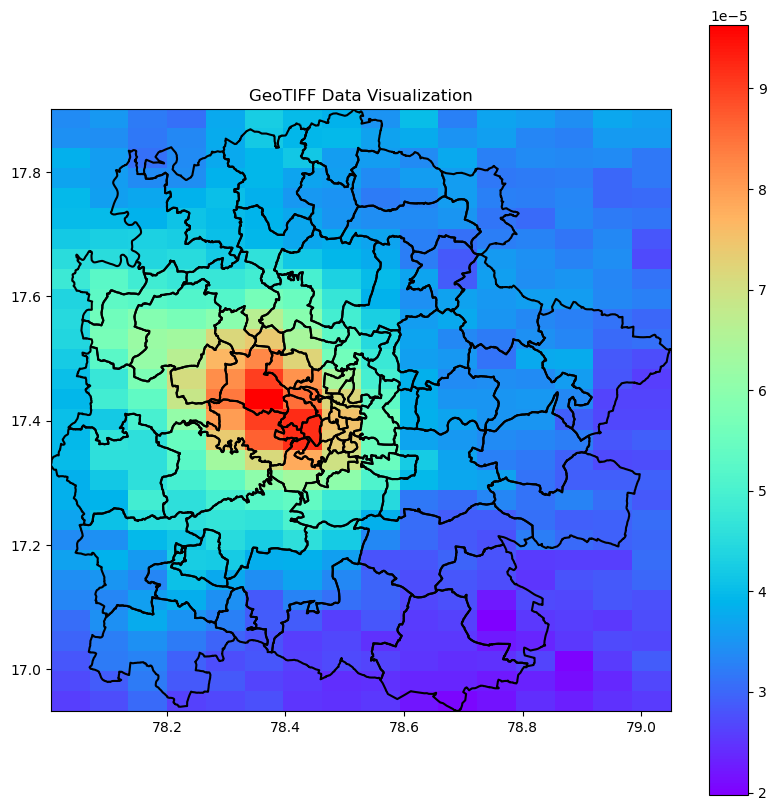

In [50]:
import geopandas as gpd

# Load the shapefile
shapefile_path = r'C:\Users\rishi\ml_projects\climate\hmda_boundary\hmda_boundary.shp'
gdf = gpd.read_file(shapefile_path)

import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# Load the GeoTIFF file
vmin = .1072  # Minimum value for normalization
vmax = .1086  # Maximum value for normalization

# Open the GeoTIFF file
tiff_file = r'C:\Users\rishi\ml_projects\climate\2023_tifs\NO2\response.tiff'
with rasterio.open(tiff_file) as dataset:
    # Create a normalization instance
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    
    # Display the image with geospatial context
    fig, ax = plt.subplots(figsize=(10, 10))
    show(dataset, ax=ax, cmap='rainbow')
    plt.title('GeoTIFF Data Visualization')
    
    # Add a colorbar with the same normalization
    plt.colorbar(ax.images[0], ax=ax, orientation='vertical')
    
    # Plot the boundary of the GeoDataFrame
    gdf.boundary.plot(ax=ax, edgecolor='black')
    
    plt.show()

In [ ]:
with rasterio.open(tiff_file) as dataset:
    # Print metadata
    print(dataset.meta)
    num_bands = dataset.count
    print(f"The GeoTIFF file has {num_bands} band(s).")
    # Get the spatial extent (bounding box)
    print("Bounds:", dataset.bounds)
    
    # Read the data as a numpy array (e.g., first band)
    data = dataset.read(1)
    print("Data shape:", data.shape)
    print(data)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 16, 'height': 30, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0653537562500004, 0.0, 78.00405826,
       0.0, -0.032295451666666725, 17.90150706)}
The GeoTIFF file has 1 band(s).
Bounds: BoundingBox(left=78.00405826, bottom=16.93264351, right=79.04971836, top=17.90150706)
Data shape: (30, 16)
[[9.55598880e-05 9.90301705e-05 1.57589835e-04 2.06313911e-04
  1.28254935e-04 1.40142045e-04 1.62054203e-04 9.34074633e-05
  1.06821135e-04 1.82844713e-04 1.42962803e-04 7.34617715e-05
  1.11314039e-04 4.64485420e-05 1.19275450e-04 1.15778079e-04]
 [7.29862004e-05 1.79004273e-04 1.35192226e-04 1.89401238e-04
  5.75881350e-05 1.64542900e-04 1.37702329e-04 1.63053992e-04
  1.22214071e-04 1.88281818e-04 6.87620632e-05 8.12419894e-05
  1.63209508e-04 1.00467267e-04 1.80698175e-04 1.78107337e-04]
 [1.41919911e-04 1.59849049e-04 1.53586632e-04 9.95733863e-05
  1.23628590e-04 1.25646329e-04 1.62349825e-04 1.91680359e-04
 